#Лабораторная работа: RFM-кластеризация покупателей (по CRISP-DM)

##Понимание данных

###2.1 Загрузка данных и структура таблицы

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Учёба/3 курс/Основы машинного обучения/ЛР4/customer_segmentation_project.csv', encoding='ISO-8859-1')

In [8]:
df.shape

(541909, 8)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [11]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


- InvoiceNo -- номер счета;
- StockCode -- код товара;
- Description -- описание товара;
- Quantity -- количество товара;
- InvoiceDate -- дата и время транзакции;
- UnitPrice -- цена за единицу товара;
- CustomerID -- идентификатор клиента;
- Country -- страна клиента;

###2.2 Первичный обзор данных

In [21]:
print('Диапазон дат: ', df['InvoiceDate'].min(), 'до', df['InvoiceDate'].max())
print("\nУникальных CustomerID:", df['CustomerID'].nunique())
print("\nУникальных StockCode:", df['StockCode'].nunique())
print("\nУникальных стран:", df['Country'].nunique())
print("\nТоп-5 стран по числу транзакций:")
print(df['Country'].value_counts().head())
print("\nПример кол-ва позиций в одном заказе (InvoiceNo=536365):")
print(df[df['InvoiceNo'] == '536365'].shape[0], "строк\n")
df[df['InvoiceNo'] == '536365'].head()

Диапазон дат:  1/10/2011 10:04 до 9/9/2011 9:52

Уникальных CustomerID: 4372

Уникальных StockCode: 4070

Уникальных стран: 38

Топ-5 стран по числу транзакций:
Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: count, dtype: int64

Пример кол-ва позиций в одном заказе (InvoiceNo=536365):
7 строк



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


###2.3 Поиск пропусков и дубликатов

In [22]:
df.isna().sum()  # Количество пропусков

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [23]:
initial_rows = df.shape[0]
df = df.dropna(subset=['CustomerID', 'Description'])
print(f"Удалено строк с пустым CustomerID/Description: {initial_rows - df.shape[0]}")

Удалено строк с пустым CustomerID/Description: 135080


In [24]:
initial_rows = df.shape[0]
data = df.drop_duplicates()
print(f"Удалено полных дубликатов: {initial_rows - df.shape[0]}")

Удалено полных дубликатов: 0


###2.4 Разведочный анализ: выбросы и аномалии

In [26]:
# Статистики Quantity и UnitPrice
print(data[['Quantity','UnitPrice']].describe(percentiles=[0.01,0.05,0.95,0.99]))

# Сколько транзакций с отрицательным Quantity (возвраты)?
print("\nКоличество строк с Quantity < 0 (возвраты):", (data['Quantity'] < 0).sum())

# Сколько транзакций с ценой 0?
print("\nКоличество строк с UnitPrice = 0 (бесплатно):", (data['UnitPrice'] == 0).sum())

# Пример очень больших Quantity
print("\nТоп-5 по Quantity:")
print(data.nlargest(5, 'Quantity')[['InvoiceNo','StockCode','Description','Quantity','UnitPrice']])

            Quantity      UnitPrice
count  401604.000000  401604.000000
mean       12.183273       3.474064
std       250.283037      69.764035
min    -80995.000000       0.000000
1%         -2.000000       0.210000
5%          1.000000       0.420000
50%         5.000000       1.950000
95%        36.000000       8.500000
99%       120.000000      15.000000
max     80995.000000   38970.000000

Количество строк с Quantity < 0 (возвраты): 8872

Количество строк с UnitPrice = 0 (бесплатно): 40

Топ-5 по Quantity:
       InvoiceNo StockCode                        Description  Quantity  \
540421    581483     23843        PAPER CRAFT , LITTLE BIRDIE     80995   
61619     541431     23166     MEDIUM CERAMIC TOP STORAGE JAR     74215   
502122    578841     84826     ASSTD DESIGN 3D PAPER STICKERS     12540   
421632    573008     84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS      4800   
206121    554868     22197               SMALL POPCORN HOLDER      4300   

        UnitPrice  
540421       

##Подготовка данных

###3.1 Очистка: удаление пропусков и дубликатов

In [27]:
# Удалим транзакции с Quantity = 0 или UnitPrice = 0, если есть
initial_rows = data.shape[0]
data = data[(data['Quantity'] != 0) & (data['UnitPrice'] != 0)]
print(f"Удалено строк с Quantity=0 или UnitPrice=0: {initial_rows - data.shape[0]}")

# Проверим, сколько отрицательных Quantity осталось
print("Отрицательных Quantity осталось:", (data['Quantity'] < 0).sum())

Удалено строк с Quantity=0 или UnitPrice=0: 40
Отрицательных Quantity осталось: 8872


###3.2 Обработка возвратов (отрицательных Quantity)

###3.3 Создание признака TotalPrice (общая сумма по строке)

In [29]:
# Добавляем столбец общей стоимости по строке (цена * количество)
df.loc[:, 'TotalPrice'] = df['UnitPrice'] * df['Quantity']

# Контроль: средняя и суммарная выручка по данным после очистки
print("Средняя сумма по строке:", round(df['TotalPrice'].mean(), 2))
print("Общая сумма всех транзакций:", round(df['TotalPrice'].sum(), 2))

Средняя сумма по строке: 20.4
Общая сумма всех транзакций: 8300065.81


###3.4 Формирование RFM-признаков

In [31]:
import numpy as np


# Преобразуем InvoiceDate в datetime, если еще не преобразован
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Определяем reference_date как день после последней даты в данных (чтобы последний день имел recency 0)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Готовим агрегирование:
# Для Frequency используем только положительные транзакции (иначе возврат повысит Frequency, что неправильно)
sales_data = df[df['InvoiceNo'].str.startswith('C') == False]

rfm = sales_data.groupby('CustomerID').agg(
  Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),
  Frequency=('InvoiceNo', 'nunique')
).reset_index()

# Monetary считаем по ВСЕМ данным (с учетом возвратов)
monetary = df.groupby('CustomerID').agg(Monetary=('TotalPrice','sum')).reset_index()

# Объединяем таблицы
rfm = pd.merge(rfm, monetary, on='CustomerID', how='left').fillna({'Recency': np.nan, 'Frequency': 0, 'Monetary': 0})

print("Пример RFM для первых 5 клиентов:")
rfm.head(5)
print("Всего клиентов в RFM таблице:", rfm.shape[0])
print("Есть ли клиенты с отрицательным Monetary?", (rfm['Monetary'] < 0).any())

Пример RFM для первых 5 клиентов:
Всего клиентов в RFM таблице: 4339
Есть ли клиенты с отрицательным Monetary? True


###3.5 Анализ распределений R, F, M и обработка выбросов

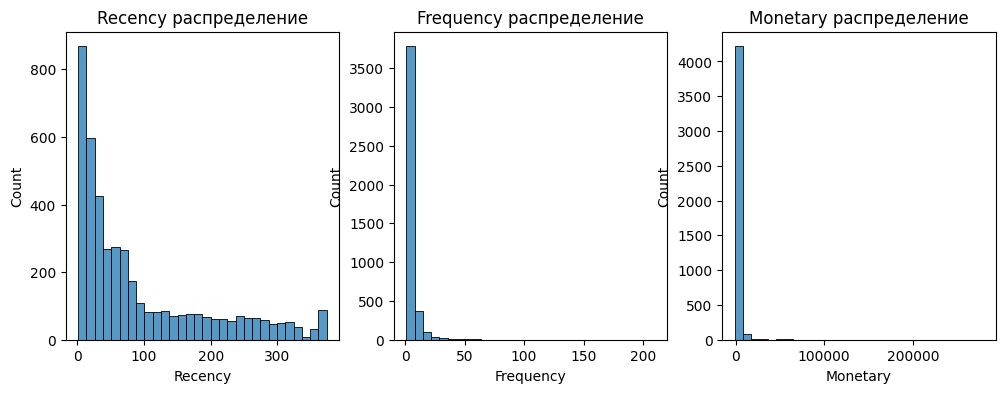

           Recency    Frequency       Monetary
count  4339.000000  4339.000000    4339.000000
mean     92.518322     4.271952    1915.297777
std     100.009747     7.705493    8247.979285
min       1.000000     1.000000   -1165.300000
50%      51.000000     2.000000     654.920000
95%     312.000000    13.000000    5657.532000
99%     369.000000    30.000000   17394.532200
max     374.000000   210.000000  279489.020000


In [32]:
# Рассмотрим распределения R, F, M
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(rfm['Recency'], bins=30)
plt.title("Recency распределение")
plt.subplot(1,3,2)
sns.histplot(rfm['Frequency'], bins=30)
plt.title("Frequency распределение")
plt.subplot(1,3,3)
sns.histplot(rfm['Monetary'], bins=30)
plt.title("Monetary распределение")
plt.show()

# Посмотрим статистики и 95-99 перцентили
print(rfm[['Recency','Frequency','Monetary']].describe(percentiles=[0.95,0.99]))

In [34]:
# Фильтр от выбросов
rfm_filtered = rfm[(rfm['Frequency'] <= 30) & (rfm['Monetary'] <= 20000)].copy()
print("Удалено клиентов-выбросов:", rfm.shape[0] - rfm_filtered.shape[0])

# Проверим размеры и описательные статистики после фильтрации
print("Оставшихся клиентов:", rfm_filtered.shape[0])
print(rfm_filtered[['Recency','Frequency','Monetary']].describe())

Удалено клиентов-выбросов: 59
Оставшихся клиентов: 4280
           Recency    Frequency      Monetary
count  4280.000000  4280.000000   4280.000000
mean     93.563318     3.696729   1335.527186
std     100.083815     4.029117   1951.488068
min       1.000000     1.000000  -1165.300000
25%      18.000000     1.000000    296.692500
50%      52.000000     2.000000    642.805000
75%     144.250000     4.000000   1547.200000
max     374.000000    30.000000  18793.410000


Стандартизируем признаки

In [35]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_filtered[['Recency','Frequency','Monetary']])

Корреляционная матрица

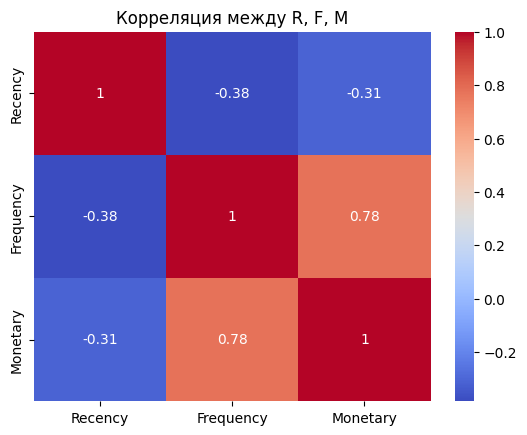

In [36]:
corr_matrix = rfm_filtered[['Recency','Frequency','Monetary']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Корреляция между R, F, M")
plt.show()

##4. Моделирование

###4.1 Выбор числа кластеров (K) для K-Means: метод “локтя” и коэффициент силуэта

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


Ks = range(2, 11)
inertias = []
sil_scores = []

for k in Ks:
  kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
  kmeans.fit(rfm_scaled) # обучение модели на стандартизированных данных
  inertias.append(kmeans.inertia_)
  # Оценка качества кластеризации силуэтом:
  labels = kmeans.labels_
  sil_scores.append(silhouette_score(rfm_scaled, labels))

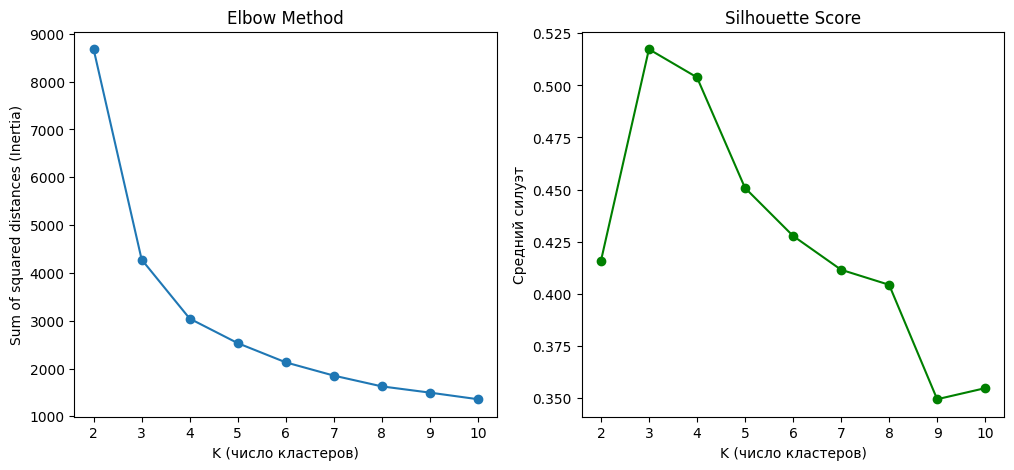

Лучший K по силуэту: 3 с оценкой 0.517


In [38]:
# Визуализация метрики локтя и силуэта
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(list(Ks), inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("K (число кластеров)")
plt.ylabel("Sum of squared distances (Inertia)")

plt.subplot(1,2,2)
plt.plot(list(Ks), sil_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("K (число кластеров)")
plt.ylabel("Средний силуэт")
plt.show()

# Найдем максимальный силуэт и соответствующий K
best_k = Ks[sil_scores.index(max(sil_scores))]
print("Лучший K по силуэту:", best_k, "с оценкой", round(max(sil_scores), 3))

###4.2 Применение K-Means с оптимальным K

In [39]:
optimal_k = best_k # если хотим вручную задать, можно просто присвоить числу, например 4
kmeans_model = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
cluster_labels = kmeans_model.fit_predict(rfm_scaled)

# Добавим метки кластеров в таблицу rfm_filtered
rfm_filtered['Cluster'] = cluster_labels

# Посмотрим, сколько клиентов в каждом кластерe
print("Распределение количества клиентов по кластерам:")
print(rfm_filtered['Cluster'].value_counts())

Распределение количества клиентов по кластерам:
Cluster
0    2822
1    1072
2     386
Name: count, dtype: int64


###4.3 Альтернативные алгоритмы кластеризации (DBSCAN Hierarchical, GMM, Spectral)

In [41]:
from sklearn.cluster import DBSCAN

# Настройка DBSCAN
# eps - радиус для соседей, min_samples - мин. точек для формирования кластера
dbscan = DBSCAN(eps=0.5, min_samples=5) # начальные значения, нужно подбирать
dbscan_labels = dbscan.fit_predict(rfm_scaled)
n_clusters_dbscan = len(set(dbscan_labels) - {-1})

print("DBSCAN нашел кластеров (не считая шум):", n_clusters_dbscan)
print("Шумовых точек (отмечено -1):", list(dbscan_labels).count(-1))

DBSCAN нашел кластеров (не считая шум): 3
Шумовых точек (отмечено -1): 91


In [46]:
def several_dbscan(rfm_scaled, eps_values=[0.3, 0.5, 0.7], min_samples=5):
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(rfm_scaled)
        n_clusters = len(set(dbscan_labels) - {-1})
        n_noise = list(dbscan_labels).count(-1)

        print(f"\nПри eps = {eps}")
        print("  Кластеров (не считая шум):", n_clusters)
        print("  Шумовых точек (-1):", n_noise)

several_dbscan(rfm_scaled)


При eps = 0.3
  Кластеров (не считая шум): 8
  Шумовых точек (-1): 189

При eps = 0.5
  Кластеров (не считая шум): 3
  Шумовых точек (-1): 91

При eps = 0.7
  Кластеров (не считая шум): 4
  Шумовых точек (-1): 32


###Иерархическая кластеризация

In [50]:
from sklearn.cluster import AgglomerativeClustering


agg = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')
agg_labels = agg.fit_predict(rfm_scaled)
print("Agglomerative кластеры распределение:")
print(pd.Series(agg_labels).value_counts())

Agglomerative кластеры распределение:
2    2343
1    1455
0     482
Name: count, dtype: int64


####Дендрограмма для полноценной иерархической кластеризации

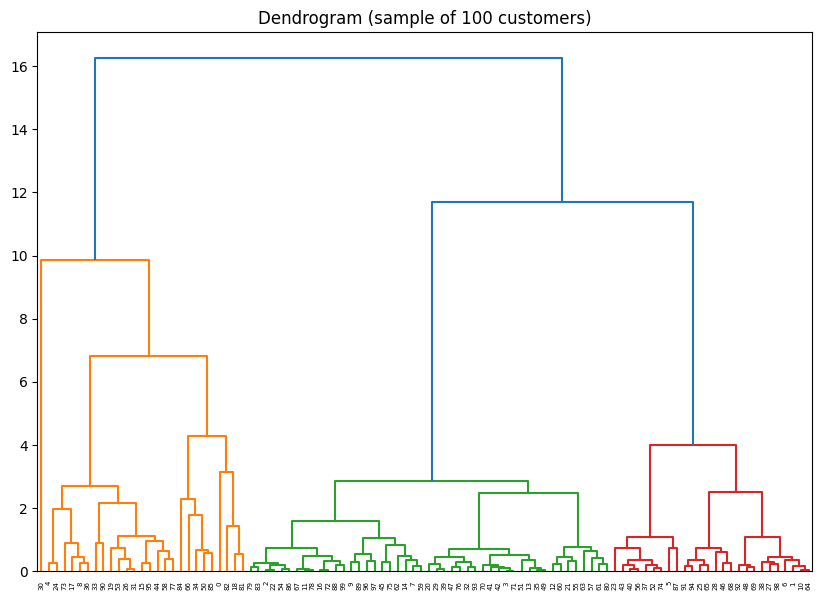

In [52]:
from scipy.cluster.hierarchy import linkage, dendrogram


# Возьмем случайно 100 клиентов для примера дендрограммы
sample_index = np.random.choice(len(rfm_scaled), size=100, replace=False)
sample_data = rfm_scaled[sample_index]

linked = linkage(sample_data, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top')
plt.title("Dendrogram (sample of 100 customers)")
plt.show()

###Gaussian Mixture (EM)

In [53]:
from sklearn.mixture import GaussianMixture


best_gmm_k = None
best_gmm_score = -1

for k in Ks:
  gmm = GaussianMixture(n_components=k, random_state=42)
  labels = gmm.fit_predict(rfm_scaled)
  score = silhouette_score(rfm_scaled, labels)
  if score > best_gmm_score:
    best_gmm_score = score
    best_gmm_k = k

print("Лучшее число кластеров для GMM по силуэту:", best_gmm_k, "силуэт:", round(best_gmm_score, 3))

# Получим метки кластеров для этого лучшего K
gmm_model = GaussianMixture(n_components=best_gmm_k, random_state=42)
gmm_labels = gmm_model.fit_predict(rfm_scaled)

Лучшее число кластеров для GMM по силуэту: 2 силуэт: 0.373


###Метод спектральной кластеризации

In [56]:
from sklearn.cluster import SpectralClustering


spectral = SpectralClustering(n_clusters=optimal_k, affinity='rbf', assign_labels='kmeans', random_state=42)
spectral_labels = spectral.fit_predict(rfm_scaled)

print("Spectral Clustering метки кластеров (первые 20):", spectral_labels[:20])
print("Распределение по кластерам Spectral:")
print(pd.Series(spectral_labels).value_counts())

Spectral Clustering метки кластеров (первые 20): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Распределение по кластерам Spectral:
0    4272
2       6
1       2
Name: count, dtype: int64


###Сравнение алгоритмов

In [58]:
# Сравнение кластеров с помощью crosstab
print("Сравнение KMeans и Spectral:")
print(pd.crosstab(cluster_labels, spectral_labels))

print("\nСравнение KMeans и Agglomerative:")
print(pd.crosstab(cluster_labels, agg_labels))

print("\nСравнение KMeans и GMM:")
print(pd.crosstab(cluster_labels, gmm_labels))

print("\nСравнение KMeans и DBSCAN:")
print(pd.crosstab(cluster_labels, dbscan_labels))

Сравнение KMeans и Spectral:
col_0     0  1  2
row_0            
0      2822  0  0
1      1072  0  0
2       378  2  6

Сравнение KMeans и Agglomerative:
col_0    0     1     2
row_0                 
0      101   386  2335
1        0  1069     3
2      381     0     5

Сравнение KMeans и GMM:
col_0    0     1
row_0           
0      977  1845
1       22  1050
2      386     0

Сравнение KMeans и DBSCAN:
col_0  -1     0   1   2
row_0                  
0       5  2817   0   0
1       7  1065   0   0
2      79   292  10   5


In [59]:
# Оценка silhouette_score

print("\nSilhouette Scores:")
print("KMeans:", silhouette_score(rfm_scaled, cluster_labels))
print("Spectral:", silhouette_score(rfm_scaled, spectral_labels))
print("Agglomerative:", silhouette_score(rfm_scaled, agg_labels))

# Для DBSCAN исключим шумовые точки (-1)
mask = dbscan_labels != -1
if sum(mask) > 0:
    print("DBSCAN (без шума):", silhouette_score(rfm_scaled[mask], dbscan_labels[mask]))
else:
    print("DBSCAN: нет точек без шума для оценки силуэта")

print("GMM:", silhouette_score(rfm_scaled, gmm_labels))


Silhouette Scores:
KMeans: 0.5173645329286419
Spectral: 0.7740236146792727
Agglomerative: 0.42871646782417305
DBSCAN (без шума): 0.6360703148816652
GMM: 0.3730511573758817


###4.4 Визуализация кластеров

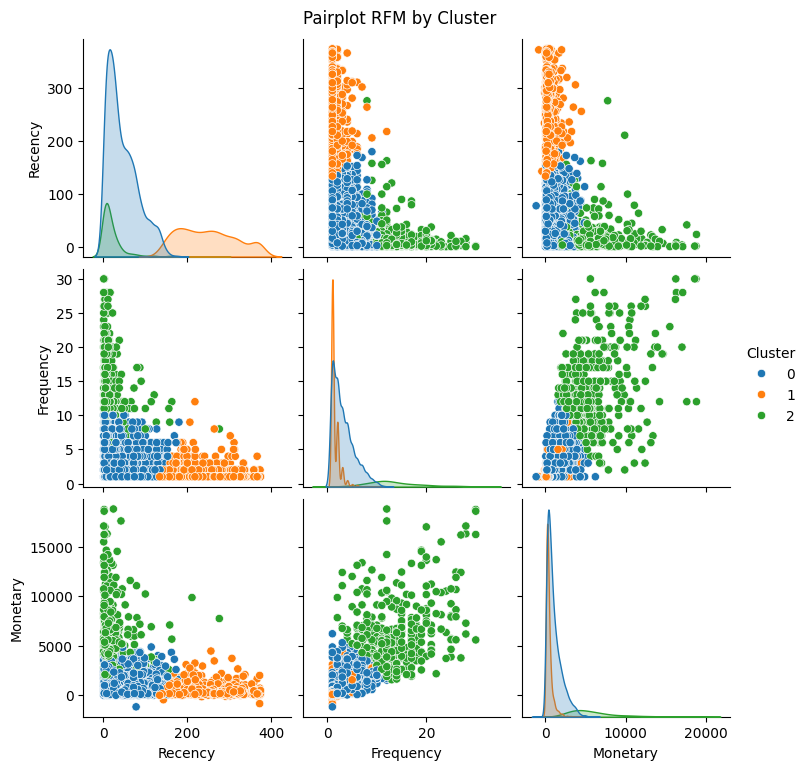

In [60]:
import seaborn as sns


sns.pairplot(rfm_filtered, vars=['Recency','Frequency','Monetary'], hue='Cluster', palette='tab10')
plt.suptitle("Pairplot RFM by Cluster", y=1.02)
plt.show()

####2D PCA проекция

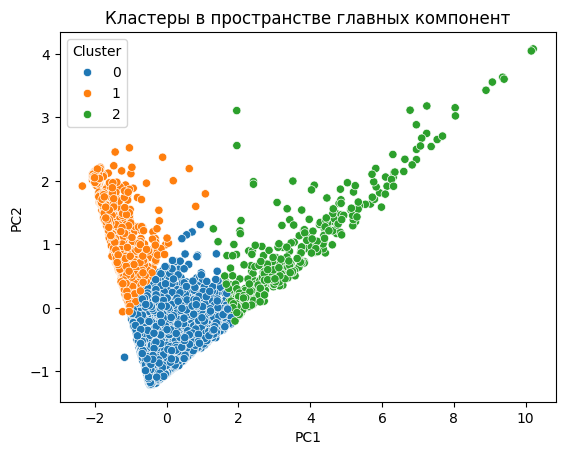

In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
# DataFrame для удобства
pca_df = pd.DataFrame(rfm_pca, columns=['PC1','PC2'], index=rfm_filtered.index)
pca_df['Cluster'] = rfm_filtered['Cluster']

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title("Кластеры в пространстве главных компонент")
plt.show()

####UMAP проекция

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


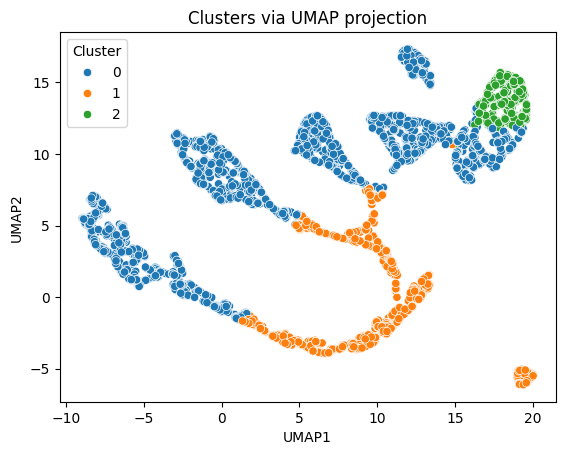

In [62]:
import umap


# Обучаем UMAP на стандартизированных данных
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
rfm_umap = reducer.fit_transform(rfm_scaled)
umap_df = pd.DataFrame(rfm_umap, columns=['UMAP1','UMAP2'], index=rfm_filtered.index)
umap_df['Cluster'] = rfm_filtered['Cluster']

sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Cluster', palette='tab10')
plt.title("Clusters via UMAP projection")
plt.show()

###4.5 Визуализация профилей кластеров: радарные диаграммы (Radar Charts)

Вычисление среднего RFM  по кластерам

In [63]:
cluster_summary = rfm_filtered.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count' # число клиентов в кластере
}).rename(columns={'CustomerID': 'NumCustomers'})
cluster_summary = cluster_summary.round(1)
cluster_summary

,Recency,Frequency,Monetary,NumCustomers
Cluster,,,,
0,45.2,3.2,1043.0,2822
1,247.3,1.5,421.3,1072
2,19.9,13.5,6012.9,386


Радарный график

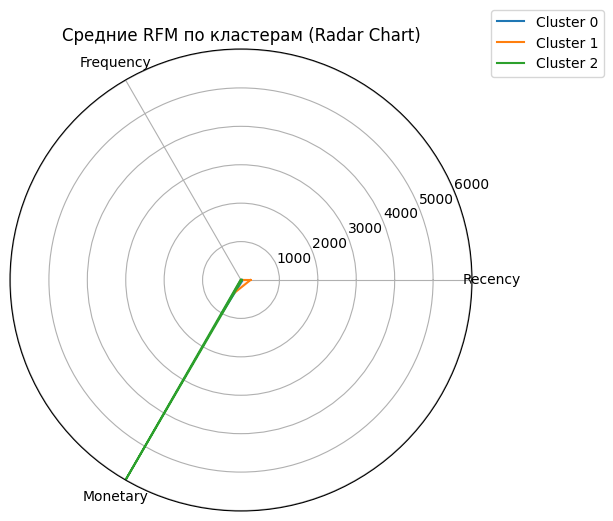

In [64]:
import numpy as np


# Список категорий
categories = ['Recency','Frequency','Monetary']
num_vars = len(categories)

# Угол для каждой категории в радианах
angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
angles += [angles[0]] # замыкаем круг

# Подготовка полотна
plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)

# Чертим одну окружность для максимального значения (можно взять максимумы из cluster_summary)
max_values = cluster_summary[categories].max().values
ax.set_ylim(0, max(max_values)) # радиальная шкала от 0 до максимума среди средних

# Подписи осей по кругу
plt.xticks(angles[:-1], categories)

# Для каждого кластера строим линию
for cluster, row in cluster_summary.iterrows():
  values = row[categories].tolist()
  values += [values[0]] # повторяем первый показатель в конец для замыкания
  ax.plot(angles, values, label=f'Cluster {cluster}')
  ax.fill(angles, values, alpha=0.1)


plt.title("Средние RFM по кластерам (Radar Chart)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()